In [1]:
# use the configuration file requirements.txt to install the specified packages with the specified version.
# !pip install -q -r requirements.txt

!pip install -q gradio
!pip install -q torch
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q bert-extractive-summarizer 
!pip install -q protobuf 

     |████████████████████████████████| 3.6 MB 10.3 MB/s 
     |████████████████████████████████| 206 kB 38.2 MB/s 
     |████████████████████████████████| 1.9 MB 38.5 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 3.5 MB 41.1 MB/s 
     |████████████████████████████████| 961 kB 39.1 MB/s 
     |████████████████████████████████| 2.9 MB 13.0 MB/s 
     |████████████████████████████████| 3.3 MB 50.4 MB/s 
     |████████████████████████████████| 895 kB 33.2 MB/s 
     |████████████████████████████████| 596 kB 43.5 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 1.2 MB 11.0 MB/s 


In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM #Huggingface transformer
import torch

#For paraphrasing
from nltk.tokenize import sent_tokenize
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import nltk
nltk.download('punkt')
#For interface
import gradio as gr


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
 device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
paraphrase_model_name = 'tuner007/pegasus_paraphrase' 
paraphrase_tokenizer = PegasusTokenizer.from_pretrained(paraphrase_model_name)
paraphrase_model = PegasusForConditionalGeneration.from_pretrained(paraphrase_model_name).to(device)

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

In [5]:
#Create a function to generate abstract summary based on input text and pre-trained model provided
'''
Function name : GenerateSummary
Input params :
      inp - abstract text whose summary will be generated
      pretrained_model_selected - pretrained model name
      max_pct - max percent of Original text to be the cap for summary length
'''
def GenerateSummary(inp,pretrained_model_selected):
  paraphrased_abstract=""
  paraphrased_summary=""
  
  try:
    pretrained_model_selected = pretrained_model_selected.lower() #lowercase the selected model name
    if pretrained_model_selected=="bert":
        from summarizer import Summarizer 
        bert_model=Summarizer()
        output = bert_model(inp )
        #PARAPHRASE abstract         
        paraphrased_abstract = ParaphrasePara(inp)
        #PARAPHRASE SUMMARY       
        paraphrased_summary = ParaphrasePara(output)
    else:
      
      #create auto tokenizer object
      tokenizer = AutoTokenizer.from_pretrained(pretrained_model_selected)
      #create model object
      model = AutoModelForSeq2SeqLM.from_pretrained(pretrained_model_selected)
      #Save model to device
    
      model = model.to(device)

      #Preprocess the input text
      preprocess_text = inp.strip().replace("\n","")
      tokenized_text = tokenizer.encode(preprocess_text, return_tensors="pt").to(device)
      #input ids
      summary_ids = model.generate(
                  tokenized_text,
                  max_length=512, 
                  num_beams=5,
                  repetition_penalty=2.5, 
                  length_penalty=1.0, 
                  early_stopping=False
              )

      #SUMMARY of abstract
      output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
      #PARAPHRASE abstract      
      paraphrased_abstract = ParaphrasePara(inp)
      #PARAPHRASE SUMMARY      
      paraphrased_summary = ParaphrasePara(output)

  except Exception as e:
        output=" Error occured, please check with the admin: "+ str(e)
  return output,paraphrased_summary,paraphrased_abstract
  # print ("\n\nSummarized text: \n",output , "\n\nParaphrazed abstract: \n",paraphrased_abstract,"\n\nParaphrazed summary: \n",paraphrased_summary)

In [6]:
#Create a function to paraphrase sentences
'''
Function name - ParaphrasePara
input param - (string) sentences
'''
def ParaphrasePara(sentences):
  sentences=sentences.replace('.' , '.  ') #some issue with sent tokenizer. Its not tokenizing when no space after full stop
  paraphrase = []
  
  sentence_list = sent_tokenize(sentences) #Tokenize the input paragraph into different sentences
  # sentence_list
  for i in sentence_list:
    a = get_response(i,1) #Call get_response function for each sentence in the paragraph
    paraphrase.append(a)
  
  #Stylize the output
  paraphrase2 = [' '.join(x) for x in paraphrase]
  paraphrase3 = [' '.join(x for x in paraphrase2) ]
  paraphrased_text = str(paraphrase3).strip('[]').strip("'")
  # print(paraphrase)
  return paraphrased_text

In [7]:
#Create a function to paraphrase sentences using pretrained paraphrasing models

def get_response(input_text,num_return_sequences):  

  batch = paraphrase_tokenizer([input_text],truncation=True,padding='longest',  return_tensors="pt").to(device)
  translated = paraphrase_model.generate(**batch,num_beams=10, num_return_sequences=num_return_sequences, temperature=1.5)
  text_generated = paraphrase_tokenizer.batch_decode(translated, skip_special_tokens=True)
  return text_generated

In [8]:
#Create GRADIO interface
iface = gr.Interface(
  fn=GenerateSummary, 
  inputs=[gr.inputs.Textbox(label="Abstract (*Enter paragraphs)",lines=20, placeholder="Enter abstract text here...") ,
          gr.inputs.Radio(["sshleifer/distilbart-cnn-12-6","deep-learning-analytics/wikihow-t5-small","Bert", "google/pegasus-pubmed", "mayu0007/pegasus_large_covid","google/pegasus-wikihow","google/pegasus-xsum"])
        ],    
  outputs=[
           gr.outputs.Textbox(label=" Summary"),
           gr.outputs.Textbox(label=" Paraphrased Summary "),
           gr.outputs.Textbox(label=" Paraphrased abstract") ],title= "Auto summarization and paraphrasing"  )
iface.launch(debug=False)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://52358.gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://52358.gradio.app')

##Output

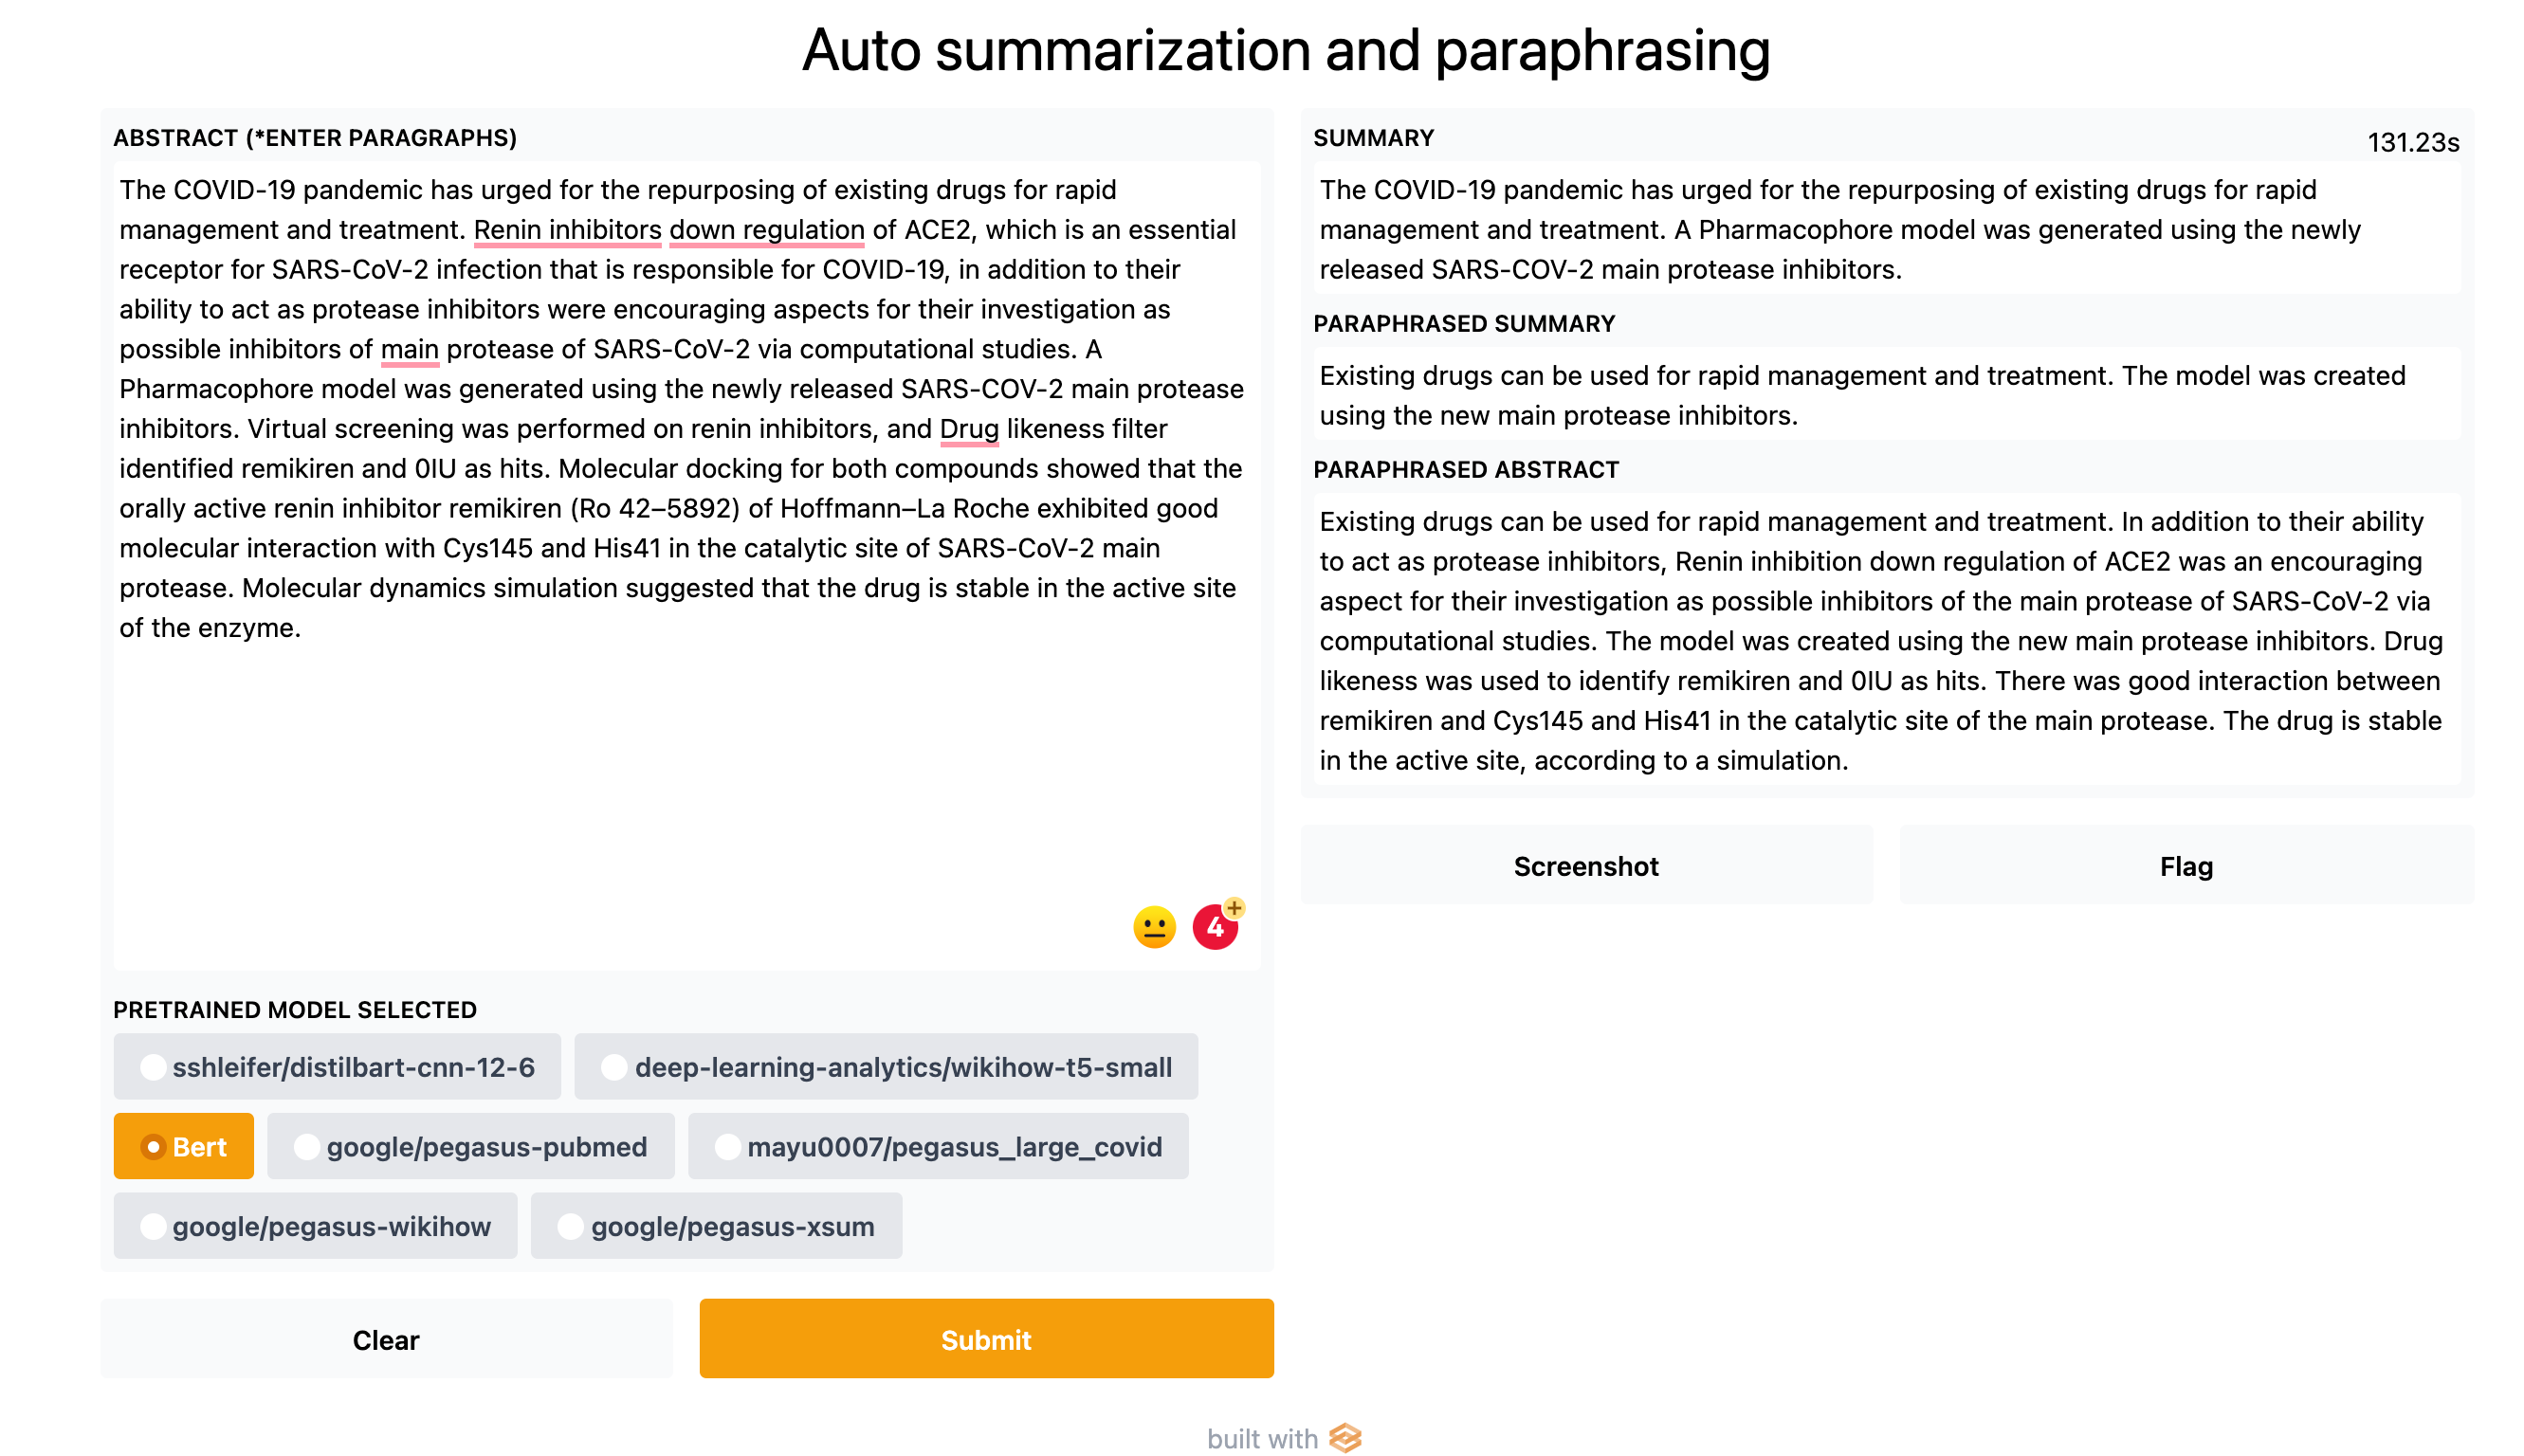